In [1]:
import pandas as pd
import numpy as np
import glob
import laspy
#import open3d as o3d
import cv2

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
def GetPathRelations(full_path_to_data):        
    ground_removed_image_paths = []
    laz_point_cloud_paths = []
        
    # Find full path to all images
    for path in glob.glob(full_path_to_data+'/ImagesGroundRemovedLarge/*'):
        ground_removed_image_paths.append(path)
    
    # Find full path to all laz files
    for path in glob.glob(full_path_to_data+'/LazFilesWithHeightRemoved/*'):
        laz_point_cloud_paths.append(path)
            
    ground_removed_image_paths.sort()
    laz_point_cloud_paths.sort()
    assert(len(ground_removed_image_paths)==len(laz_point_cloud_paths))
    return ground_removed_image_paths, laz_point_cloud_paths

In [3]:
def MaxMinNormalize(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return (MaxMinNormalize(arr))*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

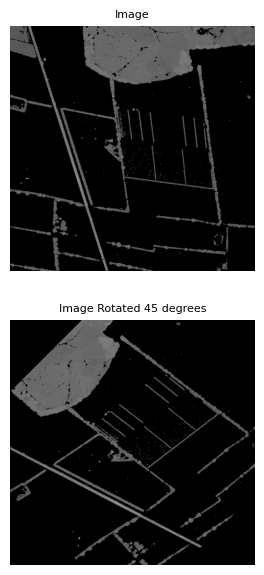

In [5]:
def GetPathRelations(full_path_to_data):        
    ground_removed_image_paths = []
    laz_point_cloud_paths = []
        
    # Find full path to all images
    for path in glob.glob(full_path_to_data+'/ImagesGroundRemovedSmall/*'):
        ground_removed_image_paths.append(path)
    
    # Find full path to all laz files
    for path in glob.glob(full_path_to_data+'/LazFilesWithHeightRemoved/*'):
        laz_point_cloud_paths.append(path)
            
    ground_removed_image_paths.sort()
    laz_point_cloud_paths.sort()
    assert(len(ground_removed_image_paths)==len(laz_point_cloud_paths))
    return ground_removed_image_paths, laz_point_cloud_paths

all_path_relations = GetPathRelations("/home/frederik/data/TestData/data")
path_tuples = list(zip(*all_path_relations))



for path in path_tuples[:1]:
    image_path, laz_path = path
    
    # Image to training set
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = np.where(image >= 0, image, 0)
    image = image/np.max(image)
    image = (image*255).astype(np.uint8)
    
    pil_image = Image.fromarray(image)
    image_rotated = pil_image.rotate(45, expand=False)
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(7,7))
    ax0.imshow(pil_image, cmap='gray')
    ax0.set_title('Image', size=8)
    ax1.imshow(image_rotated, cmap='gray')
    ax1.set_title('Image Rotated 45 degrees', size=8)
    ax0.axis('off')
    ax1.axis('off')
    plt.savefig("rotated_image.png", dpi = 200, bbox_inches = 'tight')

In [16]:
all_path_relations = GetPathRelations("/home/frederik/data/TestData/data")
path_tuples = list(zip(*all_path_relations))

# Normalize to -1 and 1
transform_img_gray = transforms.Compose(
    [transforms.Resize((4096,4096)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

random_crop_transform = transforms.RandomCrop((128, 128))

amount_of_random_images = 10

data = []
for path in path_tuples[:1]:
    image_path, laz_path = path
    
    # Image to training set
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = np.where(image >= 0, image, 0)
    image = image/np.max(image)
    image = (image*255).astype(np.uint8)
    
    x_pixels, y_pixels = image.shape

    # Generate labels 
    las = laspy.read(laz_path, laz_backend=laspy.compression.LazBackend.LazrsParallel)

    # Generate Labels
    y_values = CastAllXValuesToImage(las.X, x_pixels).astype(np.int32)
    x_values = CastAllYValuesToImage(las.Y, y_pixels).astype(np.int32)

    powerline_mask = (las.classification == 14)
    x_powerline_values = x_values[powerline_mask]
    x_powerline_values = np.where(x_powerline_values < x_pixels, x_powerline_values, x_pixels-1)
    x_powerline_values = np.where(x_powerline_values >= 0, x_powerline_values, 0)
    
    y_powerline_values = y_values[powerline_mask]
    y_powerline_values = np.where(y_powerline_values < y_pixels, y_powerline_values, y_pixels-1)
    y_powerline_values = np.where(y_powerline_values >= 0, y_powerline_values, 0)

    labels = np.zeros((x_pixels, y_pixels)).astype(np.uint8)
    for i in range(len(x_powerline_values)):
        labels[x_powerline_values[i], y_powerline_values[i]] = 255

    # Create kernel
    kernel = np.ones((3, 3), np.uint8)
    lines_image = cv2.dilate(labels, kernel, iterations=1)

    # Create Pil Image
    lines_image = Image.fromarray(lines_image)
    image = Image.fromarray(image)

    random_rotation_values = np.random.uniform(low=2, high=358, size=amount_of_random_images)
    for random_rotation_value in random_rotation_values:
        image_rotated = transform_img_gray(image.rotate(random_rotation_value, expand=False))
        lines_image_rotated = transform_img_gray(lines_image.rotate(random_rotation_value, expand=False))
        stacked_for_cropping = torch.stack((image_rotated, lines_image_rotated), dim=0)
        data.append(stacked_for_cropping)
    
# # Randomly shuffle all of the images
np.random.shuffle(data)

# Randomly select 10% as test images.
#percent = 10
#test_data_size = (1/100)*percent
#mask = int(np.floor(len(data)*test_data_size))

# X_test = []
# Y_test = []
# for stacked in data[:mask]:
#     img, lab = stacked[0], stacked[1]
#     X_test.append(img)
#     Y_test.append(lab)

trainingImages = []
trainingLabels = []

with_powerline = 0
without_powerline = 0


random_crops = 100
for _ in range(len(data)):
    stacked = data[0]
    
    cropped_images = [random_crop_transform(stacked) for _ in range(random_crops)]
    for i in cropped_images:
        img, lab = i[0], i[1]
        # dont add completely black images to training data
        if not torch.all(img == -1):
            if torch.any(lab == 1):
                trainingImages.append(img)
                trainingLabels.append(lab)
                with_powerline += 1
            else:
                r = np.random.choice([True, False], p=[0.5, 0.5])
                if r:
                    trainingImages.append(img)
                    trainingLabels.append(lab)
                    without_powerline += 1
    data = data[1:]

print("Ratio between pl & non-pl = ", with_powerline/without_powerline)

X_train, X_val, Y_train, Y_val = train_test_split(trainingImages, trainingLabels, test_size=0.1)

print(len(X_train), len(Y_train))
#print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

# Setting up sets for trainlodader and validation loader
training_set = []
for i in range(len(X_train)):
    training_set.append([X_train[i], Y_train[i]])
    
validation_set = []
for i in range(len(Y_val)):
    validation_set.append([X_val[i], Y_val[i]])

#test_set = []
#for i in range(len(Y_test)):
#    test_set.append([X_test[i], Y_test[i]])


trainloader = torch.utils.data.DataLoader(training_set, batch_size=1, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=1, shuffle=True, num_workers=4)
#testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4)

4095
Ratio between pl & non-pl =  0.012345679012345678
221 221
25 25


In [13]:
trainingImages = []
trainingLabels = []

with_powerline = 0
without_powerline = 0

random_crops = 10000
for stacked in data:
    cropped_images = [random_crop_transform(stacked) for _ in range(random_crops)]
    for i in cropped_images:
        img, lab = i[0], i[1]
        # dont add completely black images to training data
        if not torch.all(img == -1):
            if torch.any(lab == 1):
                trainingImages.append(img)
                trainingLabels.append(lab)
                with_powerline += 1
            else:
                r = np.random.choice([True, False], p=[0.05, 0.95])
                if r:
                    trainingImages.append(img)
                    trainingLabels.append(lab)
                    without_powerline += 1

print("Ratio between pl & non-pl = ", with_powerline/without_powerline)

Ratio between pl & non-pl =  0.16427211355374763


In [15]:

print(with_powerline)
print(without_powerline)

print(len(trainingImages))
print(len(trainingLabels))


#torch.save(valloader, "valloader.pt")
#torch.save(testloader, "testloader.pt")
#torch.save(trainloader, "trainloader.pt")


3796
23108
26904
26904


In [ ]:
trainloader = torch.load("trainloader.pt")
valloader = torch.load("valloader.pt")
testloader = torch.load("testloader.pt")


In [ ]:
count = 0
for i in labelImages:
    if torch.any(i==1):
        count +=1

print("The amount of training images containing powerline: ", count/len(labelImages))

In [10]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x
    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class ConvUNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #""" Encoder """
        self.e1 = encoder_block(1, 64).cuda()
        self.e2 = encoder_block(64, 128).cuda()
        self.e3 = encoder_block(128, 256).cuda()
        self.e4 = encoder_block(256, 512).cuda()
        #""" Bottleneck """
        self.b = conv_block(512, 1024).cuda()
        #""" Decoder """
        self.d1 = decoder_block(1024, 512).cuda()
        self.d2 = decoder_block(512, 256).cuda()
        self.d3 = decoder_block(256, 128).cuda()
        self.d4 = decoder_block(128, 64).cuda()
        #""" Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0).cuda()
    
    def forward(self, inputs):
        #""" Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        #""" Bottleneck """
        b = self.b(p4)

        #""" Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        #""" Classifier """
        outputs = self.outputs(d4)
        return outputs


In [11]:
def ConvNetTraining(trainloader, valloader, Conv, lossFunction, learning_rate, epochs):
    model = Conv
    num_epochs = epochs
    criterion = lossFunction.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # loss arrays for figures
    TrainingLossArray = []
    ValidationLossArray = []

    early_stopping = 50
    notImproved = 0
    bestLoss = None
    bestModel = None
    validation_size = len(valloader.dataset)
    training_size = len(trainloader.dataset)


    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        print(f"LR = {scheduler.get_last_lr()[0]:.10f}")
        running_loss = 0.0
        for j, data in enumerate(trainloader):
            # get the input
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize            
            outputs = model(inputs.cuda())
            loss = criterion(outputs.cuda(), labels.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Appending the mean running loss
        TrainingLossArray.append(running_loss/(j+1))

        # print("Training loss: ", running_loss/j)
        # Finding validation loss
        validation_loss = 0
        with torch.no_grad():
            model.eval()
            for i, data in enumerate(valloader):
                # get the inputs
                inputs, labels = data

                #Calculates loss
                outputs = model(inputs.cuda())
                loss = criterion(outputs.cuda(), labels.cuda())
                validation_loss += loss.item()

        # Appending the mean validation loss
        ValidationLossArray.append(validation_loss/validation_size)
        print(f"epoch = {epoch}, Validation loss: {validation_loss/validation_size:.10f}, Training loss: {running_loss/training_size:.10f}")

        # Initialising params for early stopping
        if bestLoss == None:
            bestLoss = validation_loss

        # Checks for early stopping        
        if validation_loss <= bestLoss:
            notImproved = 0
            bestLoss = validation_loss
            bestModel = model
            torch.save(bestModel.state_dict(), "bestModelStateDict.pth")
        else:
            notImproved +=1
        # Converges if the training has not improved for a certain amount of iterations
        if notImproved >= early_stopping:
            break
        scheduler.step()

    torch.save(bestModel.state_dict(), "lastModelStateDict.pth")
    return bestModel, ValidationLossArray, TrainingLossArray

In [12]:
bestModel, ValidationLossArray, TrainingLossArray = ConvNetTraining(trainloader, valloader, ConvUNet(), nn.MSELoss(), 0.001, 1000)

# with open('valLoss.npy', 'wb') as f:
#     np.save(f, np.array(ValidationLossArray))

# with open('trainLoss.npy', 'wb') as f:
#     np.save(f, np.array(TrainingLossArray))


LR = 0.0010000000
epoch = 0, Validation loss: 0.0448268113, Training loss: 1.0546782517
LR = 0.0009500000
epoch = 1, Validation loss: 0.0386386823, Training loss: 0.0644065472
LR = 0.0009025000
epoch = 2, Validation loss: 0.0377913350, Training loss: 0.0642708993
LR = 0.0008573750
epoch = 3, Validation loss: 0.0366895799, Training loss: 0.0624506978
LR = 0.0008145062


KeyboardInterrupt: 